In [22]:
import json
import numpy as np
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rxntools import reaction, utils, draw
from typing import List 
from IPython.display import display
import ipywidgets as widgets

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500 # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [2]:
with open('../data/cofactors.json') as f:
    cofactors_dict = json.load(f)
cofactors_list = [cofactors_dict[key] for key in cofactors_dict.keys()]

In [3]:
JN1224_df = pd.read_csv('../data/JN1224MIN_rules.tsv',delimiter = '\t')
BRENDA_df = pd.read_csv('../data/enzymemap_v2_brenda2023.csv')

#### Visualize JN reaction rules and EnzymeMap reactions dataframes

In [4]:
JN1224_df.head(5)

,Name,Reactants,SMARTS,Products,Comments
0,rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
1,rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
2,rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
3,rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
4,rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


In [5]:
BRENDA_df.head(3)

,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num
0,0,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,0,direct,single,0.991708,True,Saccharomyces cerevisiae,[],NaN,1.1.1.1
1,0,[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]...,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,0,direct reversed,single,0.991708,True,Saccharomyces cerevisiae,[],NaN,1.1.1.1
2,1,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,0,direct,single,0.991708,True,Ogataea angusta,['H9ZGN0'],uniprot,1.1.1.1


#### Select reaction rule for which to extract reactions from EnzymeMap

In [6]:
query_rule = 'rule0004'
rxn_rule_SMARTS = list(JN1224_df[JN1224_df['Name'] == query_rule]['SMARTS'])[0]

# extract out fully atom-mapped AdH reactions from BRENDA
query_rxns_frm_BRENDA = set(BRENDA_df[BRENDA_df['rule'] == rxn_rule_SMARTS]['mapped'])

print(f'\nThere are {len(query_rxns_frm_BRENDA)} unique reactions within BRENDA under rule {query_rule}')
print('')


There are 481 unique reactions within BRENDA under rule rule0004



In [7]:
def reset_smarts_numbering(smarts):
    # Convert SMARTS to RDKit molecule
    mol = Chem.MolFromSmarts(smarts)
    if not mol:
        raise ValueError("Invalid SMARTS pattern")

    # Map old atom indices to new numbers starting at 1
    atom_map = {atom.GetIdx(): i + 1 for i, atom in enumerate(mol.GetAtoms())}

    # Update atom map numbers in the molecule
    for atom in mol.GetAtoms():
        if atom.HasProp('molAtomMapNumber'):
            atom_map_number = atom.GetProp('molAtomMapNumber')
            atom.SetProp('molAtomMapNumber', str(atom_map[atom.GetIdx()]))

    # Convert back to SMARTS
    new_smarts = Chem.MolToSmarts(mol)
    return new_smarts

#### Scroll through extracted templates for substrates

In [8]:
list_length = len(list(query_rxns_frm_BRENDA)) 

# create interactive widgets
radius_widget = widgets.IntSlider(value=1, min=1, max=4, step=1, description='Radius')
index_widget = widgets.Dropdown(
    options=list(range(list_length)),
    value=1,
    description='Index'
)
stereo_widget = widgets.Checkbox(value=True, description='Include Stereo')

# function to update output based on widget values
def update_reaction(index, radius, include_stereo):
    rxn_SMARTS = list(query_rxns_frm_BRENDA)[index]
    rxn = AllChem.ReactionFromSmarts(rxn_SMARTS)
    reactants = rxn.GetReactants()
    products = rxn.GetProducts()

    mapped_rxn = reaction.mapped_reaction(rxn_smarts=rxn_SMARTS)
    changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(
        include_cofactors=False,
        consider_stereo=include_stereo,
        cofactors_list=cofactors_list)
    
    print(f'\nChanged atoms: {changed_atoms}')

    # iterate over all reactant mols
    for reactant_mol in reactants:
        if utils.is_cofactor(mol=reactant_mol, cofactors_list=cofactors_list, consider_stereo=include_stereo):
            pass
        else:
            substrate_mol = Chem.MolFromSmiles(Chem.MolToSmiles(reactant_mol))
            print(f'\nSubstrate SMARTS: {Chem.MolToSmarts(reactant_mol)}')
            substrate_template = mapped_rxn.get_template_around_rxn_site(
                                                            atom_mapped_substrate_smarts = Chem.MolToSmarts(reactant_mol),
                                                            reactive_atom_indices = list(changed_atoms),
                                                            radius = radius,
                                                            include_stereo = include_stereo)
            break

    # iterate over all product mols
    for product_mol in products:
        if utils.is_cofactor(mol=product_mol, cofactors_list=cofactors_list, consider_stereo=include_stereo):
            pass
        else:
            print(f'\nProduct SMARTS: {Chem.MolToSmarts(product_mol)}')
            break

    print(f'\nExtracted template: {substrate_template}')
    print(f'\nFinal template: {reset_smarts_numbering(substrate_template)}')
    
    print(f'\nSubstructure matches found in substrate with final template: {substrate_mol.HasSubstructMatch(Chem.MolFromSmarts(substrate_template), 
                                                                                               useChirality = True)}')
    
    svg = draw.highlight_substructures_in_notebook(
        substrate_smarts = Chem.MolToSmiles(reactant_mol),
        substructure_smarts = substrate_template,
        allow_multiple_matches = True)

    display(svg)

# use widgets to create an interactive output
interactive_plot = widgets.interactive(
    update_reaction,
    index = index_widget,
    radius = radius_widget,
    include_stereo = stereo_widget
)

display(interactive_plot)


interactive(children=(Dropdown(description='Index', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

#### Scroll through extracted templates for both substrates and products

In [9]:
list_length = len(list(query_rxns_frm_BRENDA)) 

# create interactive widgets
radius_widget = widgets.IntSlider(value=1, min=1, max=4, step=1, description='Radius')
index_widget = widgets.Dropdown(
    options=list(range(list_length)),
    value=1,
    description='Index'
)
stereo_widget = widgets.Checkbox(value=True, description='Include Stereo')

# function to update output based on widget values
def update_reaction(index, radius, include_stereo):
    rxn_SMARTS = list(query_rxns_frm_BRENDA)[index]
    rxn = AllChem.ReactionFromSmarts(rxn_SMARTS)
    reactants = rxn.GetReactants()
    products = rxn.GetProducts()

    mapped_rxn = reaction.mapped_reaction(rxn_smarts=rxn_SMARTS)
    changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(
        include_cofactors=False,
        consider_stereo=include_stereo,
        cofactors_list=cofactors_list)
    
    print(f'\nChanged atoms: {changed_atoms}')

    # iterate over all reactant mols
    for reactant_mol in reactants:
        if utils.is_cofactor(mol=reactant_mol, cofactors_list=cofactors_list, consider_stereo=include_stereo):
            pass
        else:
            substrate_mol = Chem.MolFromSmiles(Chem.MolToSmiles(reactant_mol))
            print(f'\nSubstrate SMARTS: {Chem.MolToSmarts(reactant_mol)}')
            substrate_template = mapped_rxn.get_template_around_rxn_site(
                                                            atom_mapped_substrate_smarts = Chem.MolToSmarts(reactant_mol),
                                                            reactive_atom_indices = list(changed_atoms),
                                                            radius = radius,
                                                            include_stereo = include_stereo)
            break

    # iterate over all product mols
    for product_mol in products:
        if utils.is_cofactor(mol=product_mol, cofactors_list=cofactors_list, consider_stereo=include_stereo):
            pass
        else:
            print(f'\nProduct SMARTS: {Chem.MolToSmarts(product_mol)}')
            product_template = mapped_rxn.get_template_around_rxn_site(
                                                            atom_mapped_substrate_smarts = Chem.MolToSmarts(product_mol),
                                                            reactive_atom_indices = list(changed_atoms),
                                                            radius = radius,
                                                            include_stereo = include_stereo)
            break

    print(f'\nFinal template: {reset_smarts_numbering(substrate_template)} >> {reset_smarts_numbering(product_template)}')
    
    svg = draw.highlight_substructures_in_notebook(
        substrate_smarts = Chem.MolToSmiles(reactant_mol),
        substructure_smarts = substrate_template,
        allow_multiple_matches = True)

    display(svg)
    
    svg = draw.highlight_substructures_in_notebook(
        substrate_smarts = Chem.MolToSmiles(product_mol),
        substructure_smarts = product_template,
        allow_multiple_matches = True)

    display(svg)

# use widgets to create an interactive output
interactive_plot = widgets.interactive(
    update_reaction,
    index = index_widget,
    radius = radius_widget,
    include_stereo = stereo_widget
)

display(interactive_plot)


interactive(children=(Dropdown(description='Index', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

#### Tally up the total number of templates extracted

In [10]:
def count_templates_for_monosubstrate_rxns(radius: int, include_stereo: bool, query_rxns: any) -> int:

    all_templates = []
    
    for index, _ in enumerate(query_rxns):
    
        rxn_SMARTS = list(query_rxns)[index]
        rxn = AllChem.ReactionFromSmarts(rxn_SMARTS)
        reactants = rxn.GetReactants()
        products = rxn.GetProducts()
    
        mapped_rxn = reaction.mapped_reaction(rxn_smarts=rxn_SMARTS)
        changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(include_cofactors=False, 
                                                                                     consider_stereo=include_stereo,
                                                                                     cofactors_list=cofactors_list)
    
        for reactant_mol in reactants:
            if utils.is_cofactor(mol=reactant_mol, cofactors_list=cofactors_list, consider_stereo=include_stereo):
                pass
            else:
                substrate_mol = Chem.MolFromSmiles(Chem.MolToSmiles(reactant_mol))
                
                template = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = Chem.MolToSmarts(reactant_mol),
                                                                   reactive_atom_indices = list(changed_atoms),
                                                                   radius = radius,
                                                                   include_stereo = include_stereo)
    
                template = reset_smarts_numbering(template)
                all_templates.append(template)
                break
    
    return len(set(all_templates))

In [11]:
r1_wo_stereo = count_templates_for_monosubstrate_rxns(radius = 1, include_stereo = False, query_rxns = query_rxns_frm_BRENDA)
r1_w_stereo = count_templates_for_monosubstrate_rxns(radius = 1, include_stereo = True, query_rxns = query_rxns_frm_BRENDA)

r2_wo_stereo = count_templates_for_monosubstrate_rxns(radius = 2, include_stereo = False, query_rxns = query_rxns_frm_BRENDA)
r2_w_stereo = count_templates_for_monosubstrate_rxns(radius = 2, include_stereo = True, query_rxns = query_rxns_frm_BRENDA)

r3_wo_stereo = count_templates_for_monosubstrate_rxns(radius = 3, include_stereo = False, query_rxns = query_rxns_frm_BRENDA)
r3_w_stereo = count_templates_for_monosubstrate_rxns(radius = 3, include_stereo = True, query_rxns = query_rxns_frm_BRENDA)

r4_wo_stereo = count_templates_for_monosubstrate_rxns(radius = 4, include_stereo = False, query_rxns = query_rxns_frm_BRENDA)
r4_w_stereo = count_templates_for_monosubstrate_rxns(radius = 4, include_stereo = True, query_rxns = query_rxns_frm_BRENDA)

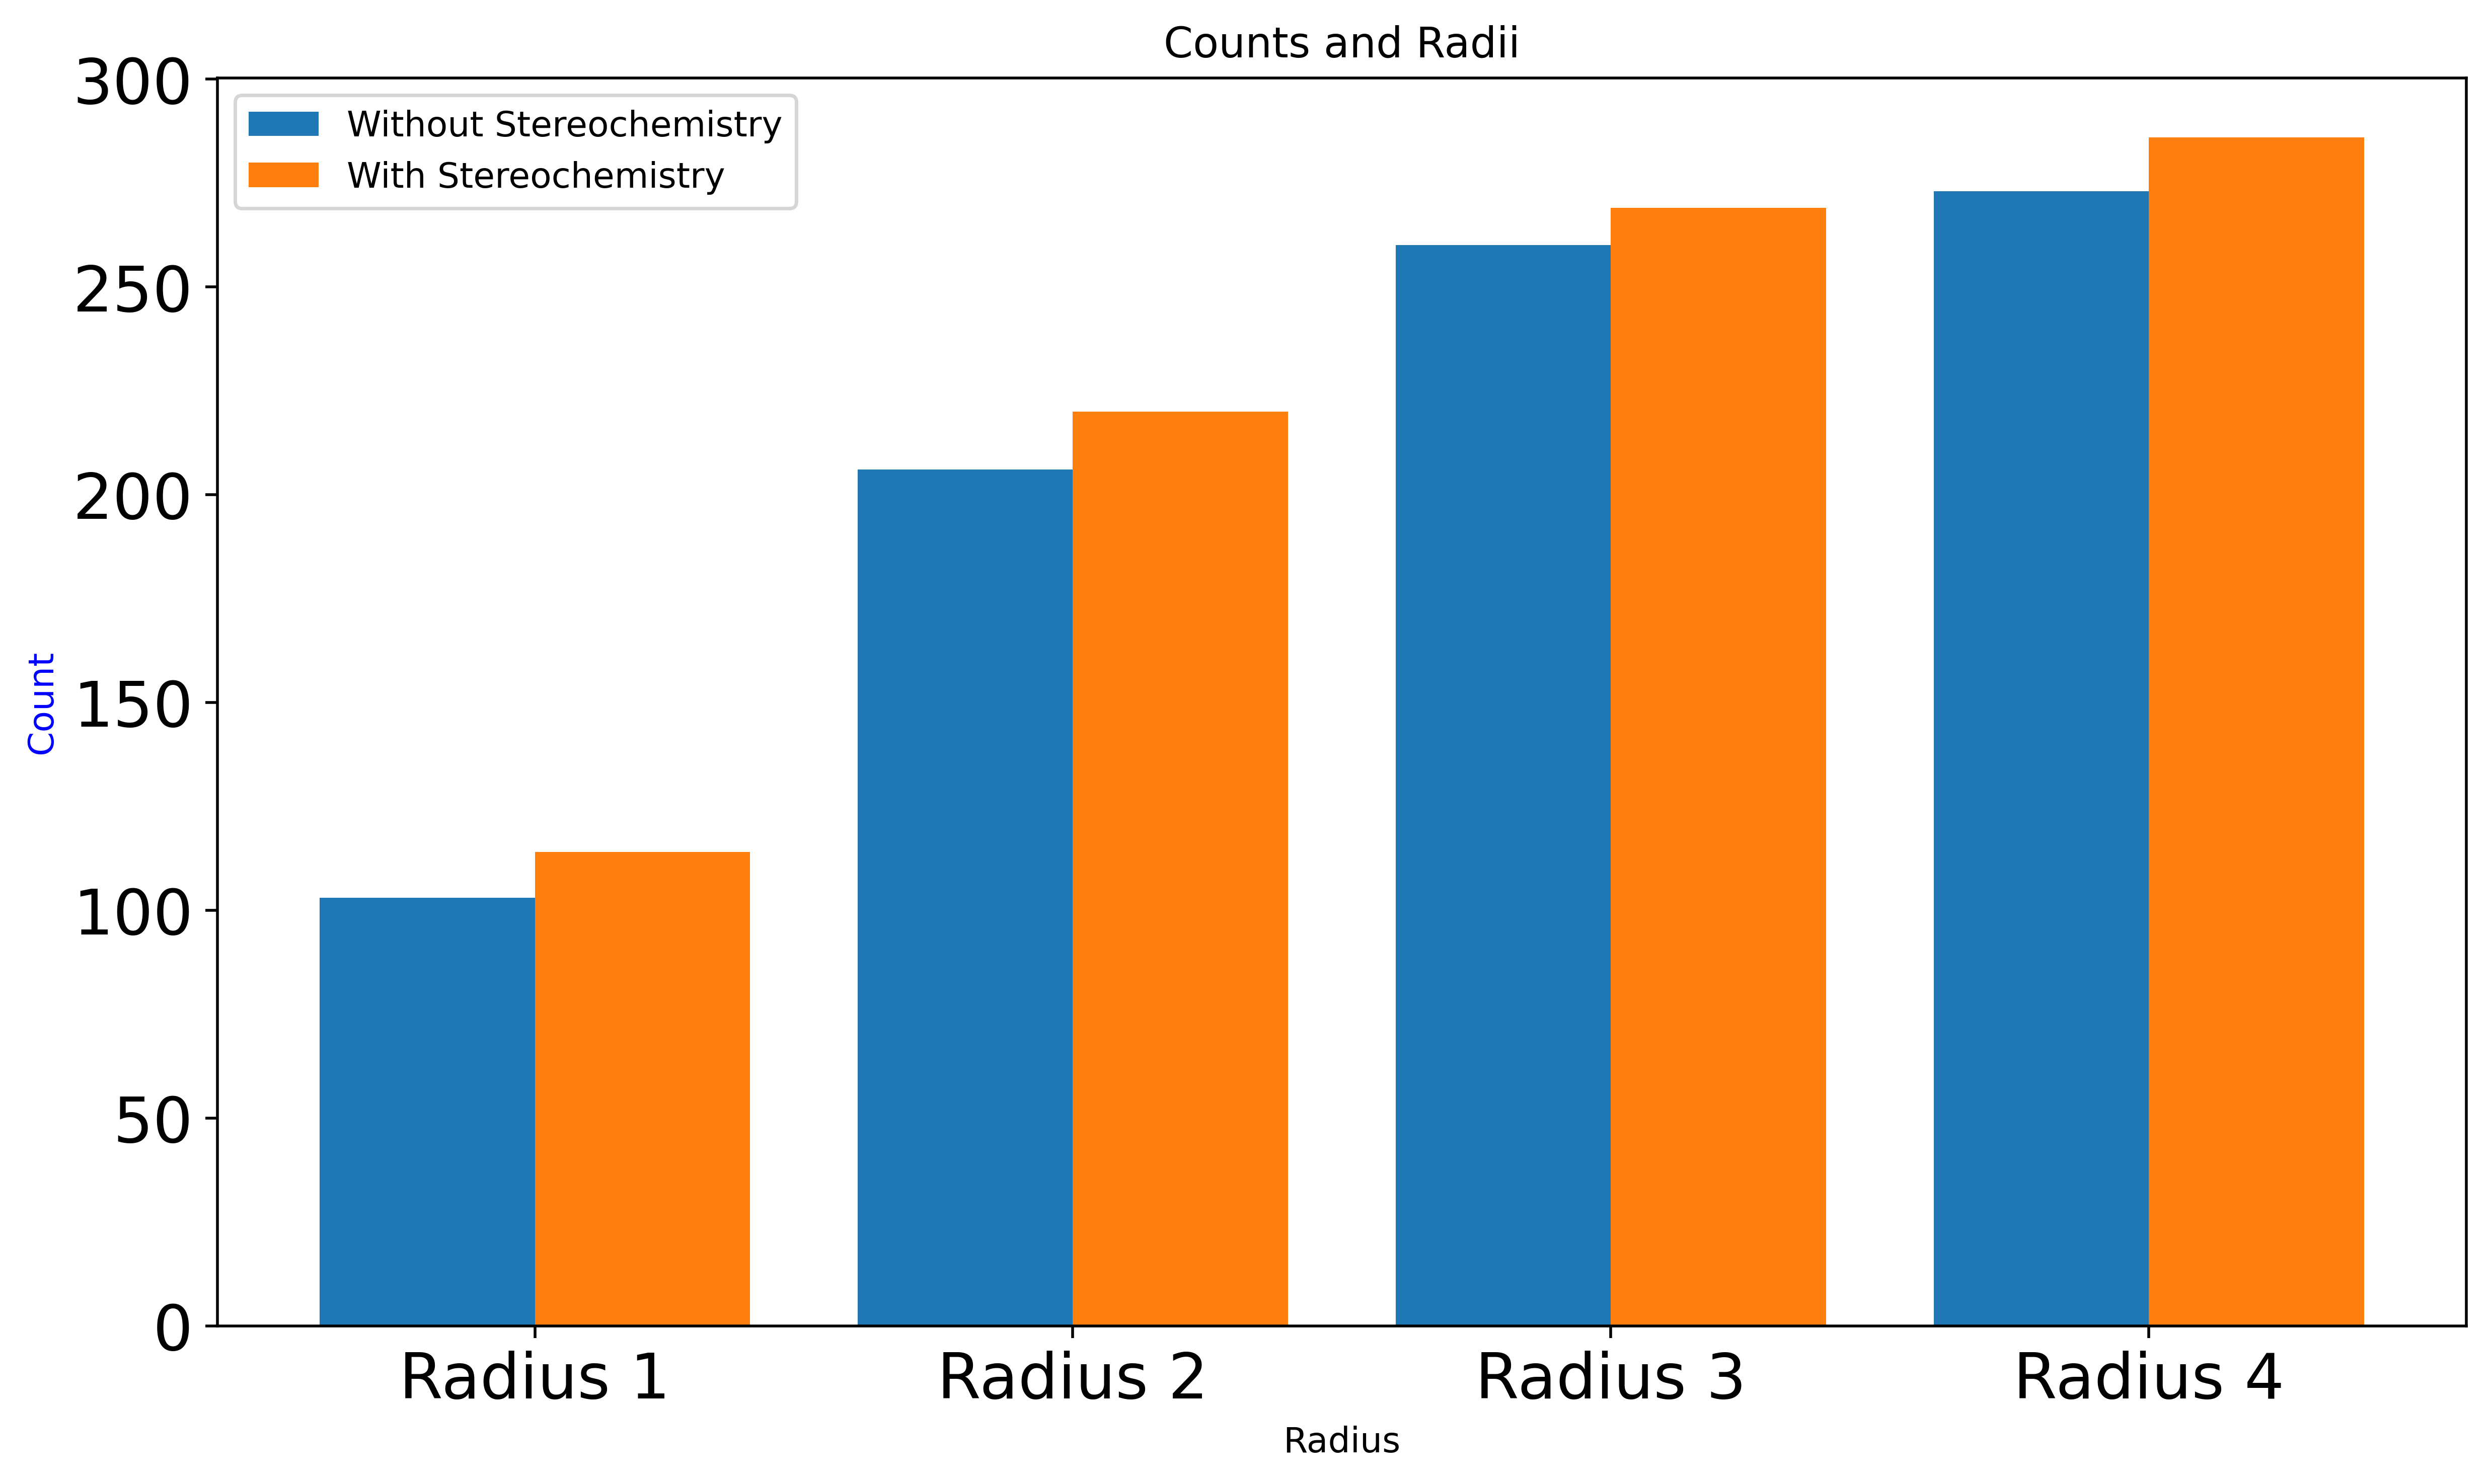

In [26]:
counts_wo_stereo = [r1_wo_stereo, r2_wo_stereo, r3_wo_stereo, r4_wo_stereo]
counts_w_stereo = [r1_w_stereo, r2_w_stereo, r3_w_stereo, r4_w_stereo]
radii = [1, 2, 3, 4]

x = np.arange(len(radii))  # Positions for each radius
bar_width = 0.4  # Width of each bar

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis: counts
bars1 = ax1.bar(x - bar_width/2, counts_wo_stereo, bar_width, label='Without Stereochemistry')
bars2 = ax1.bar(x + bar_width/2, counts_w_stereo, bar_width, label='With Stereochemistry')

ax1.set_xlabel('Radius')
ax1.set_ylabel('Count', color='b')
ax1.set_title('Counts and Radii')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Radius {r}' for r in radii])
ax1.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor='black')

plt.tight_layout()
plt.show()